In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from kernel import KernelComputer, KernelRegressor
from ranking import BasicFasSolver, IlpSolver, AC, IL, SP, DF
from dataloader import Synthesizer
from ranking.fassolver.embedding import get_sym_embs

In [2]:
%matplotlib inline
np.random.seed(0)

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [3]:
m = 4
n_test = 200

n_train = 80
corruption = .65
skewed = True

# corruption = .5
# n_train = 40
# skewed = False

datagen = Synthesizer('RK-' + str(m))
ind_map = datagen.loader.ind_map

x_train, (y_train, y_sc_tr) = datagen.get_trainset(n_train, verbose=True)
x_test, (y_test, y_score) = datagen.get_testset(n_test, verbose=True)

S_train = datagen.synthetic_corruption(y_train, corruption, skewed=skewed, y_score=y_sc_tr)

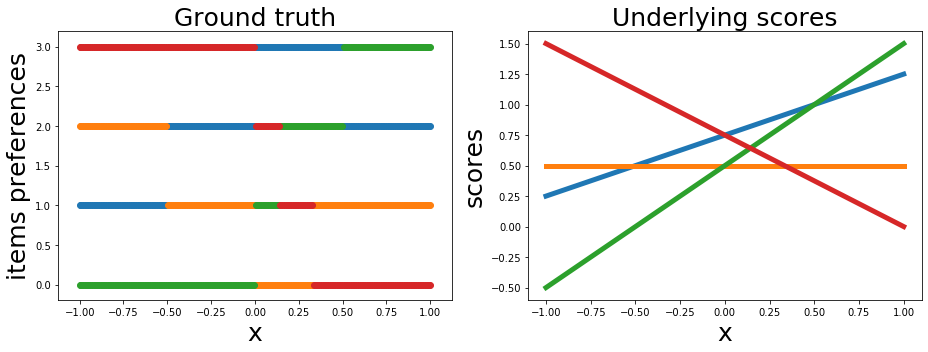

In [4]:
def show_setting(x, y, y_score, ind_map):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13,5))
    y = get_sym_embs(y, ind_map).sum(axis=-1).argsort()
    for i in range(y.shape[1]):
        ax1.scatter(x, (y == i).argmax(axis=1))
        ax2.plot(x, y_score[i], linewidth=5)
    ax1.set_title('Ground truth', size=25)
    ax1.set_ylabel('items preferences', size=25)
    ax2.set_title('Underlying scores', size=25)
    ax2.set_ylabel('scores', size=25)
    for ax in [ax1, ax2]:
        ax.set_xlabel("x", size=25)
    fig.tight_layout()
    return fig

show_setting(x_test, y_test, y_score, ind_map).savefig('savings/rk/setting.pdf')

### Show training data with corruption

In [5]:
def get_observed(S_train, ind_map):
    m = len(ind_map)
    observed = np.zeros((S_train.shape[0], m), dtype=np.int)
    for j in range(m):
        for i in range(j):
            seen = S_train[:, ind_map[i, j]] != 0
            observed[:, i] += seen
            observed[:, j] += seen
    return observed

observed = get_observed(S_train, ind_map)

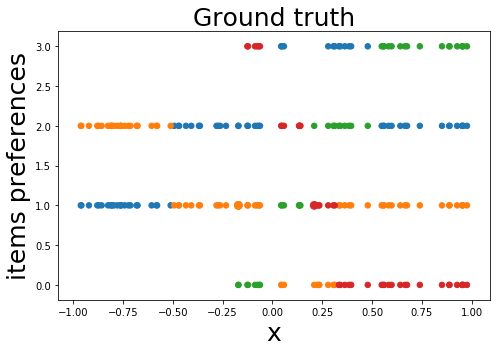

In [6]:
def show_training_set(x, y, S, ind_map):
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Get observed
    m = len(ind_map)
    observed = np.zeros((S_train.shape[0], m), dtype=np.int)
    for j in range(m):
        for i in range(j):
            seen = S_train[:, ind_map[i, j]] != 0
            observed[:, i] += seen
            observed[:, j] += seen

    # Plot figure accordingly
    y = get_sym_embs(y, ind_map).sum(axis=-1).argsort()
    for i in range(y.shape[1]):
        ind = observed[:, i].astype(np.bool_)
        ax.scatter(x[ind], (y == i).argmax(axis=1)[ind], s=30*observed[:, i][ind])
    ax.set_title('Ground truth', size=25)
    ax.set_ylabel('items preferences', size=25)
    ax.set_xlabel("x", size=25)
    fig.tight_layout()
    return fig

show_training_set(x_train, y_train, S_train, ind_map).savefig('savings/rk/training.pdf')

In [7]:
kernel_type = 'Gaussian'
# kernel_type = 'Laplacian'
sigmas = [5e-1, 3e-1, 2e-1, 1e-1]
lambdas = [1e3, 1e0, 1e-1, 1e-3, 1e-6]

# sigmas = [1e-1]
# lambdas = [1e3, 1, 1e-3, 1e-6]

In [8]:
kernel = KernelComputer(kernel_type, sigma=1)
kernel_reg = KernelRegressor(kernel)
kernel_reg.set_support(x_train[:, np.newaxis])

solver = IlpSolver(ind_map)
solver.choose_solver_method('primal')
solver.shut_up()
# solver = BasicFasSolver(ind_map)

msolver = IlpSolver(ind_map)
msolver.choose_solver_method('dual')
msolver.shut_up()

met_ac = AC(kernel_reg.kernel, msolver)
met_il = IL(kernel_reg.kernel, msolver)
met_df = DF(kernel_reg.kernel, msolver)

In [9]:
best_err_df, best_err_il = 2 * (np.inf,)

for sigma in sigmas:
    kernel_reg.update_sigma(sigma)
    for lambd in lambdas:
        kernel_reg.update_lambda(lambd)

        alpha = kernel_reg(x_train[:, np.newaxis])
        alpha /= alpha.max()
        # Stabilize CPLEX
        alpha *= 1e5
        y_dis = DF.disambiguation(alpha, S_train, 10e-6, solver)
        met_df.beta = kernel_reg.K_inv @ y_dis

        met_il.train(x_train[:, np.newaxis], S_train, lambd)

        y_df = met_df(x_test[:, np.newaxis], verbose=False)        
        y_il = met_il(x_test[:, np.newaxis], verbose=False)
        
        err_df = ((2*(y_df > 0) - 1) != y_test).mean()
        err_il = ((2*(y_il > 0) - 1) != y_test).mean()
     
        if err_df < best_err_df:
            best_err_df = err_df
            best_y_df = y_df
            best_dis = y_dis
            best_s_df = sigma
            best_l_df = lambd
        if err_il < best_err_il:
            best_err_il = err_il
            best_y_il = y_il
            best_s_il = sigma
            best_l_il = lambd    
        print(end='.')

....................

In [10]:
print(best_err_df, best_err_il)
print(best_s_df, best_s_il, best_l_df, best_l_il)

0.165 0.2966666666666667
0.2 0.3 1000.0 0.001


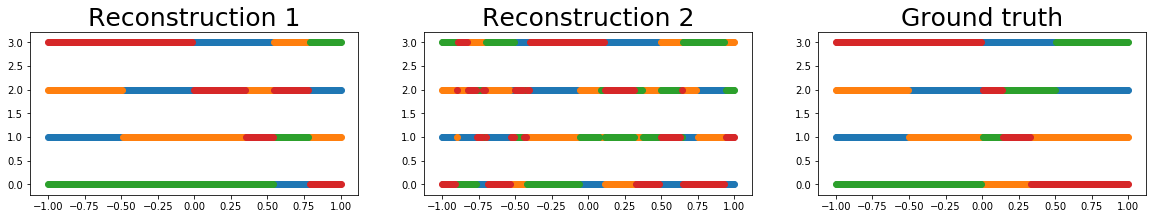

In [11]:
def show_reconstruction(x, y_1, y_2, y_test, ind_map):
    m = len(ind_map)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 3))

    s_1 = get_sym_embs(y_1, ind_map).sum(axis=1).argsort()[:,::-1]
    s_2 = get_sym_embs(y_2, ind_map).sum(axis=1).argsort()[:,::-1]
    s_t = get_sym_embs(y_test, ind_map).sum(axis=1).argsort()[:,::-1]
    for i in range(m):
        ax1.scatter(x, (s_1==i).argmax(axis=1))
        ax2.scatter(x, (s_2==i).argmax(axis=1))
        ax3.scatter(x, (s_t==i).argmax(axis=1))

    ax1.set_title("Reconstruction 1", size=25)
    ax2.set_title("Reconstruction 2", size=25)
    ax3.set_title("Ground truth", size=25)
    return fig


show_reconstruction(x_test, best_y_df, best_y_il, y_test, ind_map).savefig('savings/rk/reconstruction.pdf')

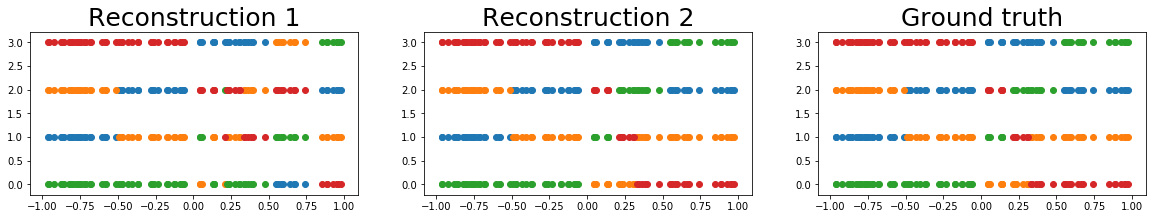

In [12]:
show_reconstruction(x_train, best_dis, y_train, y_train, ind_map);

## Varying corruption

In [13]:
np.random.seed(0)

In [14]:
m = 4
skewed = False

nb_folds = 8
corruptions = [0, .3, .5, .7, .9]
sigmas = [1, 5e-1, 1e-1]
lambdas = [1e6, 1e3, 1e0, 1e-3, 1e-6]

n_train = 30
n_test = 50

In [15]:
datagen = Synthesizer('RK-' + str(m))
ind_map = datagen.loader.ind_map

kernel = KernelComputer(kernel_type, sigma=1)
kernel_reg = KernelRegressor(kernel)
kernel_reg.set_support(x_train[:, np.newaxis])

solver = IlpSolver(ind_map)
solver.choose_solver_method('primal')
solver.shut_up()

msolver = IlpSolver(ind_map)
msolver.choose_solver_method('dual')
msolver.shut_up()

met_ac = AC(kernel_reg.kernel, msolver)
met_il = IL(kernel_reg.kernel, msolver)
met_df = DF(kernel_reg.kernel, msolver)

In [16]:
shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))

err_ac = -np.ones(shape_err)
err_il = -np.ones(shape_err)
err_df = -np.ones(shape_err)

x_test, (y_test, y_score) = datagen.get_testset(n_test, verbose=True)
for fold in range(nb_folds):
    x_train, (y_train, y_sc_tr) = datagen.get_trainset(n_train, verbose=True)
    kernel_reg.set_support(x_train[:, np.newaxis])
    n_train, dim = x_train[:, np.newaxis].shape    

    for i_s, c_sigma in enumerate(sigmas):
        sigma = c_sigma * dim
        kernel_reg.update_sigma(sigma)

        for i_l, c_lambda in enumerate(lambdas):
            lambd = c_lambda / np.sqrt(n_train)
            kernel_reg.update_lambda(lambd)
            alpha_train = kernel_reg(x_train[:, np.newaxis])
            alpha_train += alpha_train.T
            # Stabilize CPLEX
            alpha_train /= alpha_train.max()
            alpha_train *= 1e5

            for i_c, corruption in enumerate(corruptions):
                S_train = datagen.synthetic_corruption(y_train, corruption, skewed=skewed, y_score=y_sc_tr)                

                y_df = DF.disambiguation(alpha_train, S_train, 1e-3, solver)
                met_df.beta = kernel_reg.K_inv @ y_df
        
                met_il.train(x_train[:, np.newaxis], S_train, lambd)
                met_ac.train(x_train[:, np.newaxis], S_train, lambd)

                y_df = met_df(x_test[:, np.newaxis], verbose=False)        
                y_il = met_il(x_test[:, np.newaxis], verbose=False)
                y_ac = met_ac(x_test[:, np.newaxis], verbose=False)
            
                err_df[i_c, fold, i_s, i_l] = ((2*(y_df > 0) - 1) != y_test).mean()
                err_il[i_c, fold, i_s, i_l] = ((2*(y_il > 0) - 1) != y_test).mean()
                err_ac[i_c, fold, i_s, i_l] = ((2*(y_ac > 0) - 1) != y_test).mean()
                print((corruption * 10) // 1, end=',')

0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,7.0,9.0,0,3.0,5.0,

In [17]:
mus = np.empty((3, len(corruptions)))
stds = np.empty((3, len(corruptions)))
best_lambdas = np.empty((3, len(corruptions)))
best_sigmas = np.empty((3, len(corruptions)))

for err, i in zip([err_ac, err_il, err_df], [0, 1, 2]):
    tmp = err.reshape(err.shape[0], err.shape[1], -1)
    mu = tmp.mean(axis=1)
    std = tmp.std(axis=1)
    ind = mu.argmin(axis=-1)
    for j in range(len(ind)):
        mus[i, j] = mu[j, ind[j]]
        stds[i, j] = std[j, ind[j]]
        best_lambdas[i, j] = lambdas[ind[j] % len(lambdas)]
        best_sigmas[i, j] = sigmas[ind[j] // len(lambdas)]

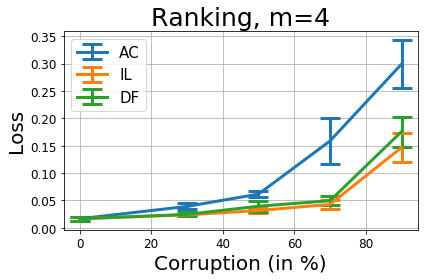

In [18]:
fig, ax = plt.subplots()
a = ax.errorbar([100*i for i in corruptions[:]], mus[0][:], .5*stds[0][:], capsize=10, linewidth=3, capthick=3)
b = ax.errorbar([100*i for i in corruptions[:]], mus[1][:], .5*stds[1][:], capsize=10, linewidth=3, capthick=3)
c = ax.errorbar([100*i for i in corruptions[:]], mus[2][:], .5*stds[2][:], capsize=10, linewidth=3, capthick=3)
ax.legend([a, b, c], ['AC', "IL", "DF"], prop={'size':15})
ax.grid()
ax.set_title('Ranking, m=%d' %m, size=25)
ax.set_ylabel('Loss', size=20)
ax.set_xlabel('Corruption (in %)', size=20)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
fig.savefig('savings/RK-10.pdf')

In [19]:
best_sigmas, best_lambdas

(array([[0.1, 0.1, 0.5, 0.5, 1. ],
        [0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1]]),
 array([[1.e-03, 1.e+03, 1.e+00, 1.e+00, 1.e+00],
        [1.e-03, 1.e+00, 1.e+00, 1.e+06, 1.e+06],
        [1.e-03, 1.e+00, 1.e+00, 1.e+06, 1.e+03]]))